In [292]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy import linalg

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, classification_report

from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# set sim hyperparameters
sim_size = int(1e4)
random_seed = 42

# Simulate a Single Distribution

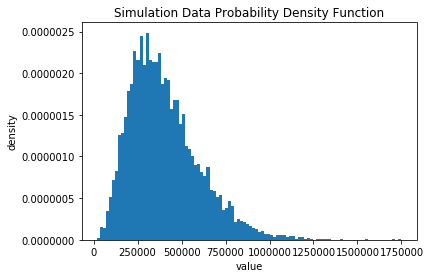

In [240]:
# simulate continuous variable (e.g. income)
dist1 = stats.gamma.rvs(a=4, loc=10, scale=1e5, size=sim_size, random_state=random_seed).astype(int)
dist1 = np.round(a=dist1, decimals=-3)

plt.title('Simulation Data Probability Density Function')
plt.xlabel('value')
plt.ylabel('density')
plt.hist(dist1, bins=100, density=True)
plt.show()

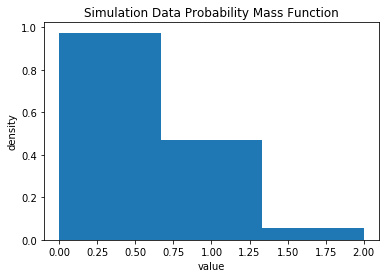

In [241]:
# simulate categorical variable (e.g. accomodation)
dist2 = stats.binom.rvs(n=2, p=0.2, size=sim_size, random_state=random_seed)

plt.title('Simulation Data Probability Mass Function')
plt.xlabel('value')
plt.ylabel('density')
plt.hist(dist2, bins=3, density=True)
plt.show()

In [246]:
# merge several distributions
dataset1_ = np.append(dist1.reshape(-1, 1), dist2.reshape(-1, 1), axis=1)

# Merge Several Distributions
Find covariance matrix such that $C \cdot C^T=r$

In [248]:
# covariating variables
y1_ = stats.binom.rvs(n=1, p=0.15, size=sim_size, random_state=random_seed)

dataset1 = np.append(dataset1_, y1_.reshape(-1, 1), axis=1)

method = 'cholesky'

r = np.array([[1, 0.2, 0.7],
              [0.2, 1, 0.3],
              [0.7 ,0.3, 1]])

c = linalg.cholesky(r, lower=True)

dataset1 = np.dot(c, dataset1.T).T

In [249]:
stats.describe(dataset1)

DescribeResult(nobs=10000, minmax=(array([19000.,  3800., 13300.]), array([1749000.,  349800., 1224300.])), mean=array([403228.        ,  80645.98025879, 282259.76404458]), variance=array([3.93450301e+10, 1.57380190e+09, 1.92790655e+10]), skewness=array([0.98080671, 0.98080682, 0.98080662]), kurtosis=array([1.43009462, 1.4300927 , 1.43009403]))

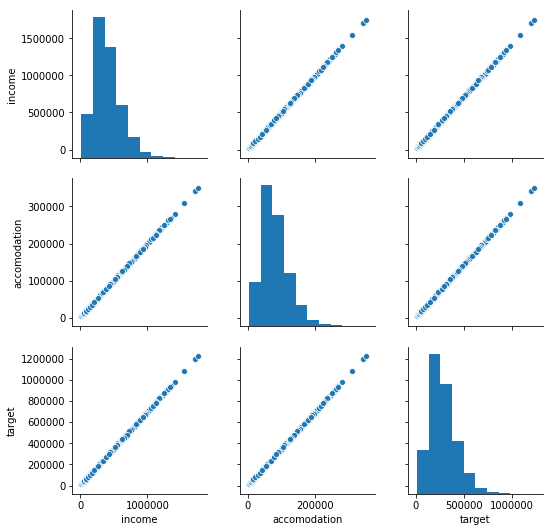

In [262]:
to_plot = pd.DataFrame(dataset1, columns=features_names_+['target'])
sns.pairplot(to_plot)
plt.show()

# Simulate a Covariating Normal Dataset

In [253]:
cols_ = ['income', 'age', 'limit_util_l6m', 'sum_interest_gen_balance_l6m', 'payment_pct_balance_lm', 'target']

trans = [lambda x: x * 1e5 - 4.5e5,
         lambda x: 18 if x*4.5 < 18 else 75 if x*4.5 > 75 else x*4.5,
         lambda x: x,
         lambda x: x,
         lambda x: x,
         lambda x: 1 if x > 0 else 0]

mu = [10, 10, 0.5, 0.5, 0.5, 0]

cov = [
       [1, 0.3, 0, 0, 0, 0.3],
       [0.3, 1, 0, 0, 0, 0],
       [0, 0, 1, 0.3, 0.7, 0.5],
       [0, 0, 0.3, 1, 0.2, 0.1],
       [0, 0, 0.7, 0.2, 1, 0.1],
       [0.3, 0, 0.5, 0.1, 0.1, 1],
      ]

m = stats.multivariate_normal.rvs(mean=mu, cov=cov, size=sim_size, random_state=random_seed).T

In [254]:
for i, col_ in enumerate(m):
    m[i] = np.vectorize(trans[i])(m[i])

In [255]:
dataset2 = pd.DataFrame(m.T, columns=cols_)

In [256]:
dataset2.head().style.format('{:.2f}')

,income,age,limit_util_l6m,sum_interest_gen_balance_l6m,payment_pct_balance_lm,target
0,546311.54,44.78,-0.30,1.74,-0.14,0.00
1,612390.52,44.48,-1.33,-0.07,-1.02,0.00
2,451068.98,33.05,0.66,-0.35,0.77,0.00
3,423646.78,45.48,1.13,1.54,2.34,0.00
4,610519.24,41.00,0.81,0.65,0.64,1.00


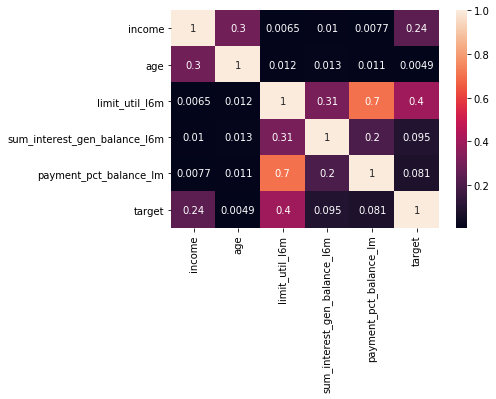

In [261]:
sns.heatmap(dataset2.corr(), annot=True)
plt.show()

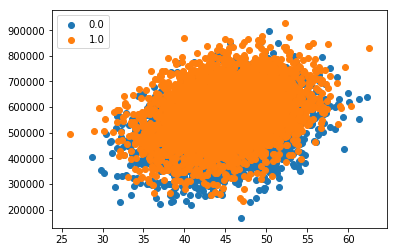

In [260]:
for t in dataset2.target.unique():
    to_plot = dataset2[dataset2.target == t]
    plt.scatter(to_plot.age, to_plot.income, label=t)
plt.legend()
plt.show()

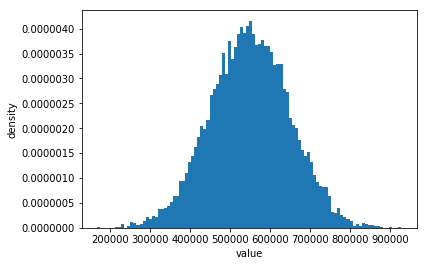

In [259]:
plt.xlabel('value')
plt.ylabel('density')
plt.hist(dataset2.income, bins=100, density=True)
plt.show()

# Model and Predict

In [305]:
X = dataset2.drop('target', axis=1)
y = dataset2.target

In [306]:
cv = 3
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(2, 10+1),
              'max_features': np.arange(2, len(X.columns) + 1),
              'max_leaf_nodes': [None] + [i for i in range(2, 11)]}
training_sizes = np.arange(0.1, 1.1, 0.1)
test_size = 0.25

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [308]:
estimator = DecisionTreeClassifier(random_state=random_seed)
scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=estimator,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=cv)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'max_features': array([2, 3, 4, 5]), 'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [309]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 5,
 'max_leaf_nodes': None}

In [310]:
grid_search.best_score_

0.7257875644119787

In [311]:
grid_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [312]:
def show_learning_curves(estimator, X, y, cv, train_sizes, scorer):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator,
                                                            X=X,
                                                            y=y,
                                                            cv=cv,
                                                            train_sizes=train_sizes,
                                                            scoring=scorer)
    
    cols_ = list(range(train_scores.shape[1]))
    cols_.extend(['size', 'type'])
    learning_curve_res = pd.DataFrame(columns=cols_)
    
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        learning_curve_res = learning_curve_res.append(frame, ignore_index=True)
    
    # with pd suppress warnings
    learning_curve_res = learning_curve_res.melt(id_vars=['size', 'type'],
                                                 var_name='cv_fit',
                                                 value_name='score')
    
    g = plt.figure(figsize=(12, 10))
    g = sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
    g.set_ylim(0, 1.)
    g.set_title('Learning Curves')
    plt.show(g)

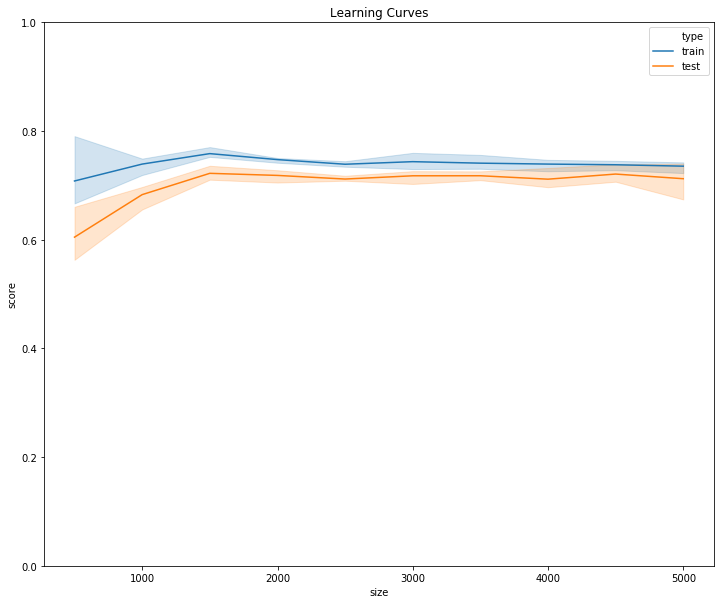

In [313]:
show_learning_curves(grid_search.best_estimator_, X_train, y_train, cv, training_sizes, scorer)

In [314]:
pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

limit_util_l6m                  0.645050
payment_pct_balance_lm          0.181298
income                          0.173651
sum_interest_gen_balance_l6m    0.000000
age                             0.000000
dtype: float64

In [315]:
print(classification_report(y_true=y_test,
                            y_pred=grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68      1258
         1.0       0.67      0.76      0.71      1242

   micro avg       0.70      0.70      0.70      2500
   macro avg       0.70      0.70      0.69      2500
weighted avg       0.70      0.70      0.69      2500



In [316]:
cross_val_score(estimator=grid_search.best_estimator_,
                X=X_test, y=y_test, scoring=scorer, cv=cv)

array([0.61979167, 0.69154229, 0.66246851])